In [1]:
import matplotlib.pyplot as plt
import numpy as np

from checking_tools import checkLabels, checkNormals, plot_sparsity
from Trefft_tools import TrefftzSpace, TrefftzFunction,  AssembleRHS, AssembleMatrix, AssembleGreenRHS#, AssembleGreenIncidentRHS
from geometry_tools import Edge
from meshes import testMesh, toyMesh, waveguideMesh, GradientMesh, squareMesh
from meshes import ScattererType
from testcases import TestCase
from matplotlib.patches import Rectangle, Circle

In [2]:




def scatterer_mask(Omega):
    pass

In [3]:
test_case = TestCase.SOUND_SOFT_SCATTERER

In [4]:
R = 10.
H = 2.


match test_case:
    case TestCase.FINE_MESH_BARRIER:
        scatterer_type = ScattererType.NONE
        Omega = GradientMesh(h_min=0.05)
        scatterer_type = ScattererType.NONE

    case TestCase.PROPAGATING_MODE:
        Omega = testMesh(H = H, h_max=H/3)
        scatterer_type = ScattererType.NONE
    case TestCase.FUNDAMENTAL_CIRCLE:
        rad = 0.3
        c = (0.,H/2)
        c = (0., 3/4*H)
        scatterer_type = ScattererType.GREEN_FUNC
        kwargs = {"facecolor" : "grey", "edgecolor" : "black", "linewidth" : 3}
        scatterer = lambda :  Circle( xy=c, radius=rad, **kwargs)
        Omega = waveguideMesh(R = R, H = H, h_max=H/3,rad = rad, c=c,  scatterer_type=scatterer_type)

    case TestCase.FUNDAMENTAL_SQUARE: # | TestCase.FUNDAMENTAL_SQUARE_PlUS_INCIDENT:
        L = H/2
        c = (0.,H/2)
        scatterer_type = ScattererType.GREEN_FUNC
        kwargs = {"facecolor" : "grey", "edgecolor" : "black", "linewidth" : 3}
        scatterer = lambda :  Rectangle( xy=(c[0]-L/2, c[1]-L/2), height=L, width=L,  **kwargs)
        Omega = squareMesh(R = R, H=H, h_max=H/3, L = L, c=c,  scatterer_type=scatterer_type)

    case TestCase.PENETRABLE_SCATTERER:
        rad = 0.3
        c = (0.,H/2)
        c =( 0., 3/4*H)
        scatterer_type = ScattererType.PENETRABLE
        Omega = waveguideMesh(R = R, H=H, h_max=H/3,rad = rad, c=c,  scatterer_type=scatterer_type)
        kwargs = {"facecolor" : "none", "edgecolor" : "black", "linewidth" : 3}
        scatterer = lambda : Circle( xy=c, radius=rad, **kwargs)

    case TestCase.SOUND_SOFT_SCATTERER:
        rad = 0.3
        c = (0.,H/2)
        #c = (0., 3/4*H)
        scatterer_type = ScattererType.SOUND_SOFT
        Omega = waveguideMesh(R = R, H=H,  h_max=H/3,rad = rad, c=c,  scatterer_type=scatterer_type)
        kwargs = {"facecolor" : "grey", "edgecolor" : "black", "linewidth" : 3}
        scatterer = lambda : Circle( xy=c, radius=rad, **kwargs)



In [5]:
match scatterer_type:
    case ScattererType.NONE:
        Edges = [ Edge(Omega, e, None)  for e in Omega.edges ]
    case _:
        Edges = [ Edge(Omega, e, c)  for e in Omega.edges ]

side_ls = np.array([E.l for E in Edges])
h_max = np.max(side_ls)
h_max

0.9945327613973622

Checking the orientation of the labels...

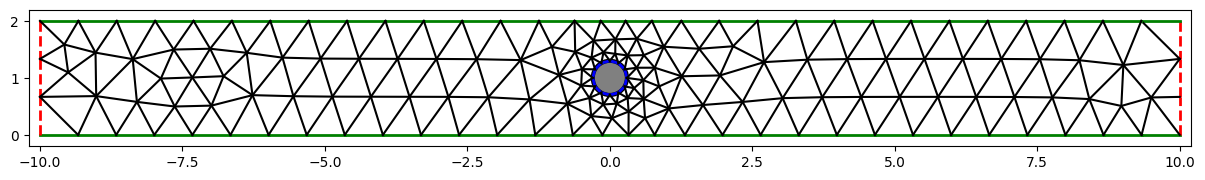

In [6]:
checkLabels(Edges, H=H)
if scatterer_type != ScattererType.NONE:
    plt.gca().add_patch(scatterer())

and the orientation of the normals...

(0.55, 1.45)

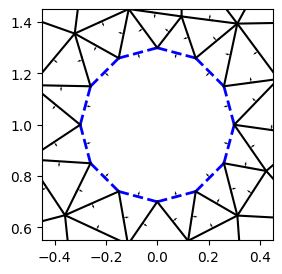

In [7]:
checkNormals(Edges)
plt.xlim([-1.5*rad,1.5*rad])
plt.ylim([c[1] - 1.5*rad, c[1]+1.5*rad])

and the definition of the "plus" and "minus" quantities...

In [8]:
  # checkPlusMinus(Edges, Baricenters) 

In [9]:
kappa_e = 8.
kappa_i = 12.


In [10]:
# #optimal angle for mode "t" : th = arcsin( lambda /  (2H)) 
# t = 2
# dth = np.arcsin( t*np.pi / (kappa_e*H))
# # optimal number of waves for mode "t":
# Nth = int(2*np.pi / dth)
# Nth 

In [26]:
Nth = 15
th = np.e/np.pi # no correct direction in the basis
#th = 0. # right direction in the basis
V = TrefftzSpace(Omega, Nth, {"Omega_i" : kappa_i , "Omega_e" : kappa_e}, th )


In [27]:
NP = 20
a = 0.5*h_max/side_ls
b = 0.5*h_max/side_ls

# a = 0.5
# b = 0.5

d_1 = 0.5
d_2 = 0.5
A = AssembleMatrix(V, Edges, Np=NP, a=a, b=b, d_1=d_1, d_2=d_2)
NDOF = A.shape[0]


In [28]:
print(f'{NDOF=}. Matrix with {np.count_nonzero(A.toarray())} non-zero entries from a total of {NDOF**2}. "fullness" ratio: {np.count_nonzero(A.toarray())/NDOF**2 * 100 : .2f}%')

NDOF=3780. Matrix with 211050 non-zero entries from a total of 14288400. "fullness" ratio:  1.48%


In [29]:
# Ncond = np.linalg.cond(A.toarray())
Ncond = -1
Ncond 

-1

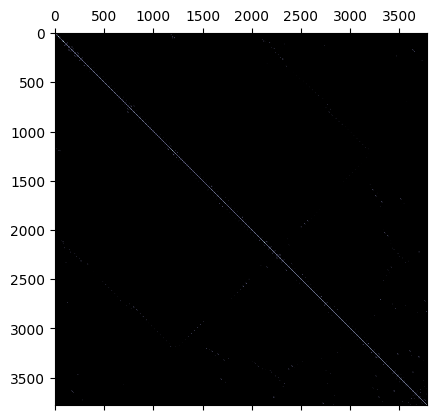

In [30]:
plot_sparsity(A)

In [40]:

match test_case:
    case TestCase.FUNDAMENTAL_CIRCLE | TestCase.FUNDAMENTAL_SQUARE:
        modes = True
        B = AssembleGreenRHS(V, Edges, kappa_e, H, a=a, y0=c[1], modes=modes)
    # case TestCase.FUNDAMENTAL_SQUARE_PlUS_INCIDENT:
    #     modes = True 
    #     t = 0
    #     B = AssembleGreenIncidentRHS(V, Edges, kappa_e, H, a, d_2, y0=c[1], t=t, modes=True)
    case _:
        t = 1
        B = AssembleRHS(V, Edges, kappa_e, H, d_2=d_2, t=t)


In [41]:
from scipy.sparse.linalg import bicgstab 
from scipy.sparse.linalg import spsolve 
A = A.tocsc()
#DOFs, _ = bicgstab(A,B)
DOFs = spsolve(A,B)
f = TrefftzFunction(V,DOFs)

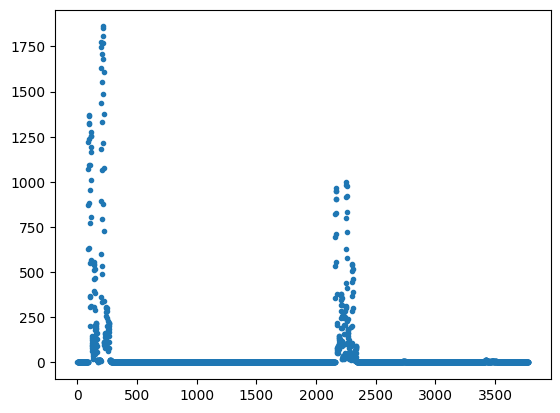

In [42]:
plt.plot(np.abs(DOFs),'.')

In [43]:
Ny = 50
Nx = 10*Ny
x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

# Z = np.reshape(f(X.ravel(), Y.ravel()), [Ny,Nx]) FIX THIS, EVALUATION SHOULD BE VECTORIZED

u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])


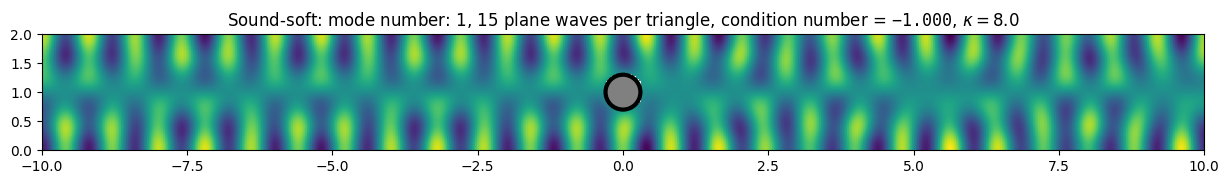

In [44]:
_, ax = plt.subplots( figsize=(15,3))

ax.imshow(np.real(u_Trefft), origin="lower", extent=[-R,R,0,H])


#checkLabels(Edges, ax)
ax.axis('square')
ax.set_xlim([-R,R])
ax.set_ylim([0,H])

match scatterer_type:
    case ScattererType.PENETRABLE:
        ax.set_title(f'Penetrable: mode number: {t}, {Nth} plane waves per triangle, condition number = $\\mathtt{{ {Ncond: .3f} }}$, $\\kappa={kappa_e:.1f}$')
    case ScattererType.SOUND_SOFT:
         ax.set_title(f'Sound-soft: mode number: {t}, {Nth} plane waves per triangle, condition number = $\\mathtt{{ {Ncond: .3f} }}$, $\\kappa={kappa_e:.1f}$')
    case ScattererType.GREEN_FUNC:
        ax.set_title(f'Green function case, {Nth} plane waves per triangle, condition number =   $\\mathtt{{ {Ncond: .3f} }}$, $\\kappa={kappa_e:.1f}$')


if scatterer_type != ScattererType.NONE:
    ax.add_patch(scatterer())

save = False
if save:
    plt.savefig(f'test_{t}_{Nth}_d2.png')


In [47]:
from FEM_solution import u_FEM_SOUNDSOFT, u_FEM_PENETRABLE
from exact_solutions import GreenFunctionImages, GreenFunctionModes

match test_case:
    case TestCase.SOUND_SOFT_SCATTERER:
        u_test = u_FEM_SOUNDSOFT(R=R, H=H, rad=rad, c = c, n=t,k=kappa_e, X=X, Y=Y)
    case TestCase.PENETRABLE_SCATTERER:
        u_test = u_FEM_PENETRABLE(R=R, H=H, rad=rad, c = c, n=t,k_e=kappa_e, k_i=kappa_i, X=X, Y=Y)
    case TestCase.FUNDAMENTAL_CIRCLE | TestCase.FUNDAMENTAL_SQUARE:
        if modes:
            u_test = np.reshape( GreenFunctionModes(kappa_e,H, np.stack([X.ravel(),Y.ravel()], axis=1), 0., c[1], M=200), (Ny,Nx))
        else:
            u_test = np.reshape( GreenFunctionImages(kappa_e,H, np.stack([X.ravel(),Y.ravel()], axis=1), 0., c[1], M=400), (Ny,Nx))
        if test_case == TestCase.FUNDAMENTAL_SQUARE:
            u_test = np.where( np.logical_and( np.abs(X-c[0])<= L/2,  np.abs(Y-c[1]) <= L/2) , np.full_like(u_test,np.nan), u_test)        
        else: 
            u_test = np.where( (X-c[0])**2 + (Y-c[1])**2 <= rad**2, np.full_like(u_test,np.nan), u_test)
    # case TestCase.FUNDAMENTAL_SQUARE_PlUS_INCIDENT:
    #     if modes:
    #         u_test = np.reshape( GreenFunctionModes(kappa_e,H, np.stack([X.ravel(),Y.ravel()], axis=1), 0., c[1], M=200), (Ny,Nx))
    #     else:
    #         u_test = np.reshape( GreenFunctionImages(kappa_e,H, np.stack([X.ravel(),Y.ravel()], axis=1), 0., c[1], M=400), (Ny,Nx))
    #     u_test = u_test + np.exp(1j*np.sqrt(kappa_e**2 - (t*np.pi/H)**2)*X)*np.cos(t*np.pi*Y/H)

    #     u_test = np.where( np.logical_and( np.abs(X-c[0])<= L/2,  np.abs(Y-c[1]) <= L/2) , np.full_like(u_test,np.nan), u_test)        

    case TestCase.PROPAGATING_MODE:
        u_test = np.exp(1j*np.sqrt(kappa_e**2 - (t*np.pi/H)**2)*X)*np.cos(t*np.pi*Y/H)



NDOF: 208655
hi


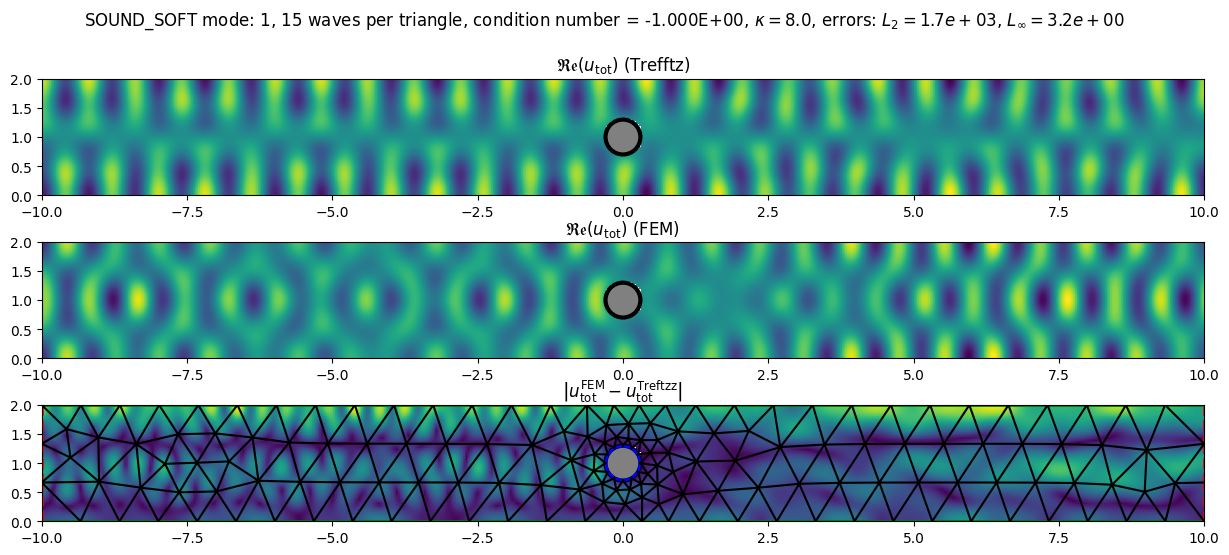

In [46]:
fig, ax = plt.subplots( nrows = 3, figsize=(15,6))


ax[0].imshow(np.real(u_Trefft), origin="lower", extent=[-R,R,0,H])
if scatterer_type != ScattererType.NONE:
    ax[0].add_patch(scatterer())
#checkLabels(Edges, ax[0])
ax[0].axis('square')
ax[0].set_xlim([-R,R])
ax[0].set_ylim([0,H])

match test_case: 
    case TestCase.PENETRABLE_SCATTERER | TestCase.PROPAGATING_MODE:
        diff = np.abs(u_Trefft - u_test)
    # case TestCase.FUNDAMENTAL_SQUARE | TestCase.FUNDAMENTAL_SQUARE_PlUS_INCIDENT:
    #     diff = np.where( np.logical_and( np.abs(X-c[0])<= L/2,  np.abs(Y-c[1]) <= L/2), 0.,  np.abs(u_Trefft - u_test))
    case _:
        diff = np.where( (X-c[0])**2 + (Y-c[1])**2> rad**2, np.abs(u_Trefft - u_test), 0.)

L2_err = np.sqrt(np.sum(diff**2)*(2*R*2*H)) 
L_inf_err = np.max(diff)


ax[1].imshow(np.real(u_test), origin="lower", extent=[-R,R,0,H])
if scatterer_type != ScattererType.NONE:
    ax[1].add_patch(scatterer())
#checkLabels(Edges, ax[1])
ax[1].axis('square')
ax[1].set_xlim([-R,R])
ax[1].set_ylim([0,H])



ax[2].imshow(np.abs(u_Trefft-u_test), origin="lower", extent=[-R,R,0,H])


checkLabels(Edges, ax[2])
if scatterer_type != ScattererType.NONE:
    ax[2].add_patch(scatterer())

ax[2].axis('square')
ax[2].set_xlim([-R,R])
ax[2].set_ylim([0,H])

match scatterer_type:
    case ScattererType.SOUND_HARD | ScattererType.SOUND_SOFT:
        fig.suptitle(f'{scatterer_type.name} mode: {t}, {Nth} waves per triangle, condition number = {Ncond: .3E}, $\\kappa={kappa_e:.1f}$, errors: $L_2={L2_err:.1e}$, $L_\\infty={L_inf_err:.1e}$')
        ax[0].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$ (Trefftz)')
        ax[1].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$ (FEM)')
        ax[2].set_title('$\\left\\vert u^\\mathrm{FEM}_\\mathrm{tot}-u^\\mathrm{Treftzz}_\\mathrm{tot}\\right\\vert$')

    case  ScattererType.PENETRABLE:
        fig.suptitle(f'{scatterer_type.name} mode: {t}, {Nth} waves per triangle, condition number = {Ncond: .3E}, $\\kappa_e={kappa_e:.1f}$, $\\kappa_i={kappa_i:.1f}$, errors: $L_2={L2_err:.1e}$, $L_\\infty={L_inf_err:.1e}$')
        ax[0].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$ (Trefftz)')
        ax[1].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$ (FEM)')
        ax[2].set_title('$\\left\\vert u^\\mathrm{FEM}_\\mathrm{tot}-u^\\mathrm{Treftzz}_\\mathrm{tot}\\right\\vert$')


    case ScattererType.GREEN_FUNC:
        fig.suptitle(f'{scatterer_type.name}, {Nth} waves per triangle, condition number = {Ncond: .3E}, $\\kappa={kappa_e:.1f}$, errors: $L_2={L2_err:.1e}$, $L_\\infty={L_inf_err:.1e}$')
        ax[0].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{sc}\\right)$ (Trefftz)')
        ax[1].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{sc}\\right)$ (Green function)')
        ax[2].set_title('$\\left\\vert G -u^\\mathrm{Treftzz}_\\mathrm{tot}\\right\\vert$')
    
    case ScattererType.NONE:
        fig.suptitle(f'{scatterer_type.name}, {Nth} waves per triangle, condition number = {Ncond: .3E}, $\\kappa={kappa_e:.1f}$, errors: $L_2={L2_err:.1e}$, $L_\\infty={L_inf_err:.1e}$')
        ax[0].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$ (Trefftz)')
        ax[1].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$ (Green function)')
        ax[2].set_title('$\\left\\vert G -u^\\mathrm{Treftzz}_\\mathrm{tot}\\right\\vert$')
    

save = False
if save:
    plt.savefig(f'mode_{t}_{Nth}_no_d2_no_wave_in_basis.png')

10.0


Text(0.5, 1.0, '$\\left|u_\\mathrm{sc}^\\mathrm{Trefftz}(R,y)-u_\\mathrm{sc}^\\mathrm{modes}(R,y)\\right|$')

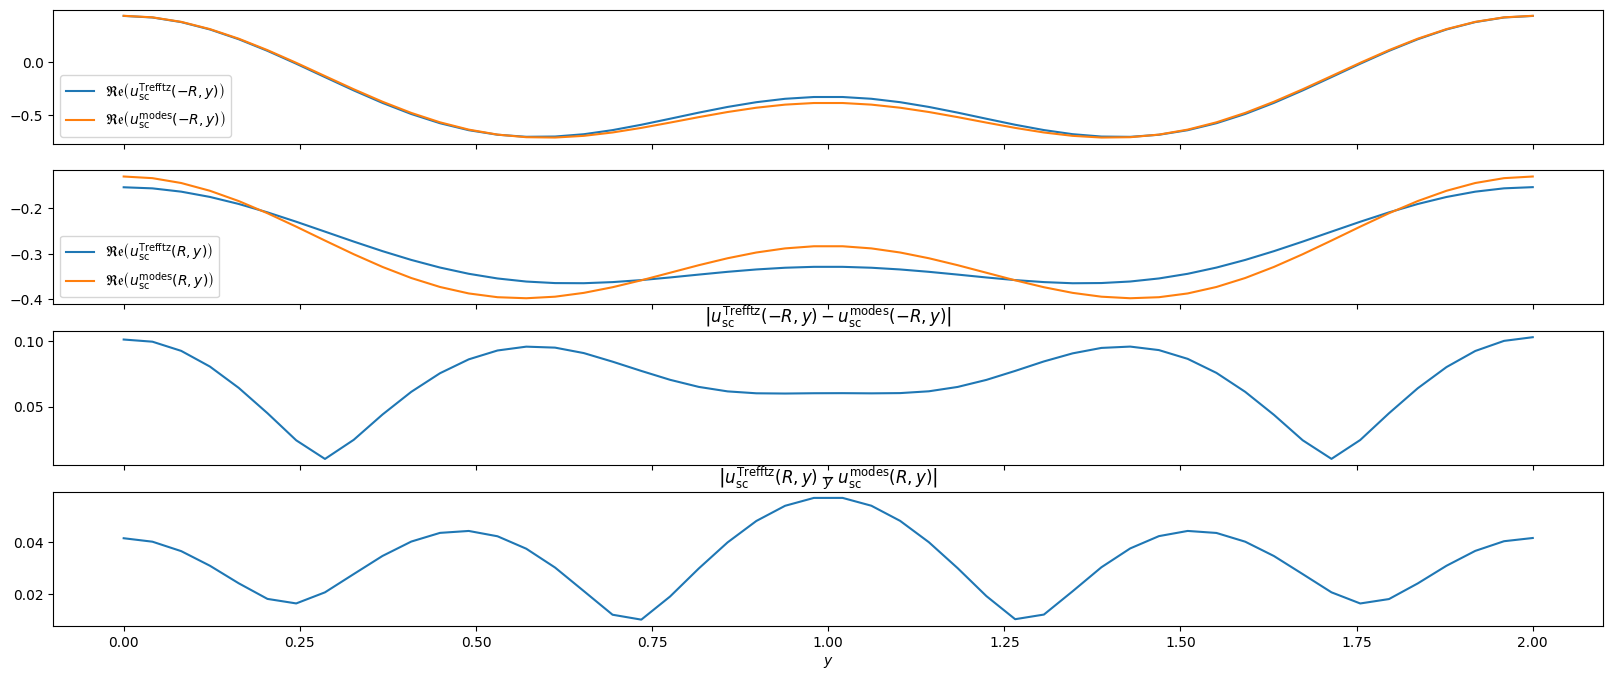

In [38]:
fig, ax = plt.subplots(nrows=4, figsize=(20,8), sharex=True)

ax[0].plot(y,np.real(u_Trefft[:,0]), label='$\\mathfrak{Re}\\left(u_\\mathrm{sc}^\\mathrm{Trefftz}(-R,y)\\right)$')
ax[0].plot(y,np.real(u_test[:,0]), label='$\\mathfrak{Re}\\left(u_\\mathrm{sc}^\\mathrm{modes}(-R,y)\\right)$')
ax[0].legend()

j_err = -1
print(x[j_err])
ax[1].plot(y,np.real(u_Trefft[:,j_err]), label='$\\mathfrak{Re}\\left(u_\\mathrm{sc}^\\mathrm{Trefftz}(R,y)\\right)$')
ax[1].plot(y,np.real(u_test[:,j_err]), label='$\\mathfrak{Re}\\left(u_\\mathrm{sc}^\\mathrm{modes}(R,y)\\right)$')
ax[1].legend()

ax[2].plot(y,np.abs(u_Trefft[:,0] - u_test[:,0]), label='$\\mathfrak{Re}\\left(u_\\mathrm{sc}\\right)$')
ax[2].set_xlabel('$y$')
ax[2].set_title('$\\left|u_\\mathrm{sc}^\\mathrm{Trefftz}(-R,y)-u_\\mathrm{sc}^\\mathrm{modes}(-R,y)\\right|$')

ax[3].plot(y,np.abs(u_Trefft[:,-1] - u_test[:,-1]), label='$\\mathfrak{Re}\\left(u_\\mathrm{sc}\\right)$')
ax[3].set_xlabel('$y$')
ax[3].set_title('$\\left|u_\\mathrm{sc}^\\mathrm{Trefftz}(R,y)-u_\\mathrm{sc}^\\mathrm{modes}(R,y)\\right|$')

# plt.legend()


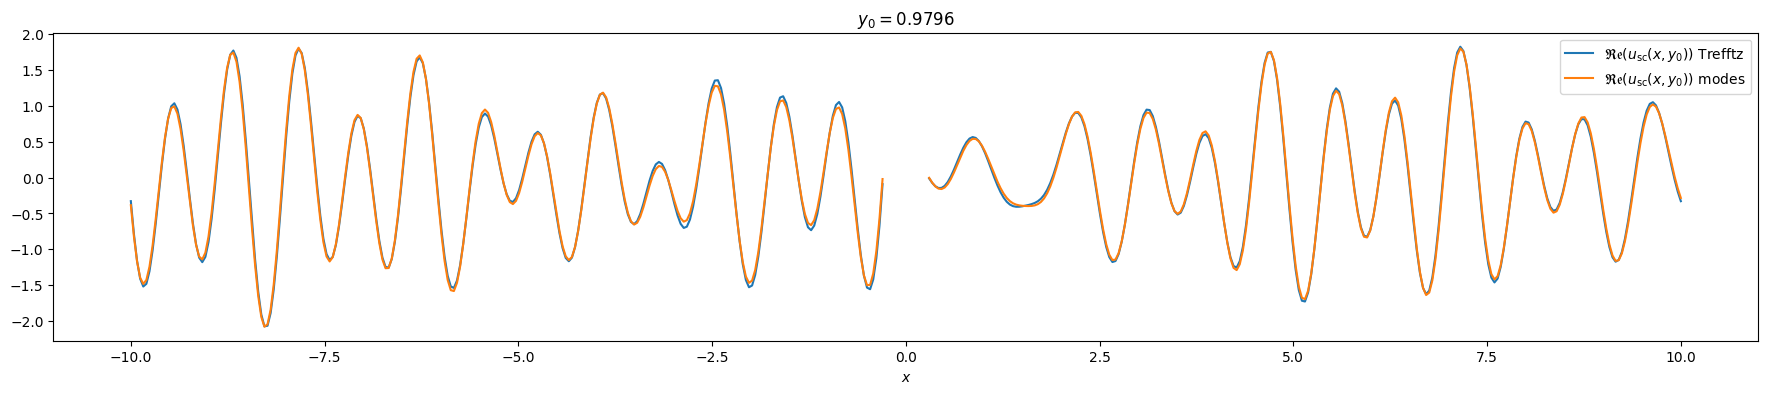

In [39]:
j=24
vmin = -3
vmax = 3
fig, ax = plt.subplots(figsize=(22,4))
ax.plot(x,np.real(u_Trefft[j,:]), label='$\\mathfrak{Re}\\left(u_\\mathrm{sc}(x,y_0)\\right)$ Trefftz')
ax.plot(x,np.real(u_test[j,:]), label='$\\mathfrak{Re}\\left(u_\\mathrm{sc}(x,y_0)\\right)$ modes')
ax.set_xlabel('$x$')
ax.set_title(f'$y_0={y[j]:.4f}$')
plt.legend(loc="upper right")


In [25]:
# T = 5
# fps = 20
# Nt = int(fps*T)
# t_ = np.linspace(0,T,Nt)
# w = 2*np.pi*1/1

# vmin = -3
# vmax = 3
# for n in range(Nt):
#     fig, ax = plt.subplots( figsize=(15,3))

#     ax.imshow(np.real(Z*np.exp(-1j*w*t_[n])), origin="lower", vmin=vmin, vmax=vmax, extent=[-R,R,-H,H], interpolation='bilinear', cmap='Blues')
#     ax.axis('square')
#     ax.set_xlim([-R,R])
#     ax.set_ylim([-H,H])
#     ax.set_title(f'mode number: {t}, {Nth} plane waves per triangle, $\\kappa={kappa_e:.1f}$, $t = \\mathtt{{{t_[n]:.2f}}}$')
#     ax.add_patch(Circle(xy=c,radius=rad, **kwargs))

#     plt.savefig(f'./r02_t1/{n:02d}.png',dpi=200)
#     plt.close()